# Proyecto - Optimización I
## Oscar Esaú Peralta Rosales y Stack Sánchez Pablo Antonio
### Maestría en computación - CIMAT

#### Parte 1 - Implementación

A continuación se presenta la implementación del paper *On the acceleration of the Barzilai-Borwein method*

Se puede acceder a él a través de:

https://arxiv.org/abs/2001.02335

In [0]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
from scipy import linalg, optimize
import matplotlib.pyplot as plt

import rosembrock
import wood

# Algoritmo Barzilai-Borwein

Implementación del método de Barzilai Borwein para realizar comparativas de los métodos

In [0]:
class BB():
    def __init__(self):
        self.__clear()


    def __clear(self):
        """ Reiniciliza los logs """
        self.x_log = []
        self.f_log = []
        self.g_norm_log = []
        self.x_best = None
        self.iters = 0


    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 a0: float = 0.001,
                 use_BB1 = True, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        x_k_prev =  None
        gk_prev= None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))


        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0

            if self.iters == 0 : 
                alpha_ok = a0
            else: 
                sk= x_k - x_k_prev
                yk= g_k - gk_prev
                if use_BB1: 
                    alpha_ok = sk.dot(sk)/sk.dot(yk)
                else: 
                    alpha_ok = sk.dot(yk)/yk.dot(yk)

            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

# Versiones de Nuevos algoritmos

In [0]:
class BB_NEW():
    """ Implementa los métodos necesarios para los cálculos de 
        los nuevos algoritmos ANGR1, ANGR2 y ANGM
    """
    def __init__(self):
        self._clear()


    def _clear(self):
        """ Reiniciliza los logs """
        self.x_log = []
        self.f_log = []
        self.g_norm_log = []
        self.x_best = None
        self.iters = 0


    def _get_q(self, g_k, gk_prev):
        """ Retorna la aproximación a q como se define en el paper """
        zeros = g_k==0
        g_k[zeros] = 1
        qk = gk_prev**2 / g_k
        qk[zeros] = 0
        return qk


    def _get_alpha_sd(self, g_k, H_k): 
        """ Retorna el valor de alṕha para descenso de gradiente estándar """
        alpha_sd = g_k.dot(g_k) / g_k@H_k@g_k 
        return alpha_sd


    def _get_alpha_bb1(self, qk_prev, g_k, H_k): 
        """ Retorna el nuevo cálculo para BB1 propuesto """
        alpha_sd = 1/self._get_alpha_sd(g_k, H_k)
        qAq = qk_prev@H_k@qk_prev
        qk_norm = qk_prev.dot(qk_prev)
        gk_norm = g_k.dot(g_k)
        qAg = qk_prev@H_k@g_k

        raiz = ((qAq/qk_norm - alpha_sd)**2 + 4*qAg / (qk_norm * gk_norm))
        den = qAq/qk_norm + alpha_sd + np.sqrt(raiz)

        return 2/den
    

    def _get_alpha_mg(self, g_k, H_k ):
        """ Retorna el cálculo de alpha para minimal gradient """
        return (g_k@H_k@g_k) / (g_k@H_k@H_k@g_k)
    

    def _get_alpha_k(self, qk, H_k):
        """ Retorna el cálculo de alpha gorrito para la obtencion de BB2 """
        return self._get_alpha_mg(qk, H_k)


    def _get_gamma_k(self, qk_prev, g_k, H_k): 
        """ Retorna el valor de gamma usado para calcular BB2 """
        return 4 * (qk_prev@H_k@H_k@g_k)**2 / (qk_prev@H_k@qk_prev * g_k@H_k@g_k)


    def _get_alpha_bb2(self, qk_prev, H_k, g_k, alpha_k_prev, alpha_mg):
        """ Retorna la nueva aproximación a BB2 """
        alpha_mg = 1 / alpha_mg
        gamma_k = self._get_gamma_k(qk_prev, g_k, H_k)
        alpha_k_prev = 1 / alpha_k_prev

        raiz= (alpha_k_prev - alpha_mg)**2 + gamma_k
        den = alpha_k_prev + alpha_mg + np.sqrt(raiz)

        return 2 / den

## ANGM

In [0]:
class ANGM(BB_NEW):
    def __init__(self):
        super(ANGM, self).__init__()


    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self._clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None

        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_bb2 = None
        alpha_mg= self._get_alpha_mg(g_k, H_k)

        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_prev = qk
                qk = self._get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_prev = alpha_k
                alpha_k = self._get_alpha_k(qk, H_k)
                alpha_ok = ak_bb1
            if self.iters >= 2:
                alpha_bb2 = self._get_alpha_bb2(qk_prev, H_k, g_k, alpha_k_prev, alpha_mg)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = alpha_bb2
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))
            alpha_mg= self._get_alpha_mg(g_k, H_k)

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

## ANGR1

In [0]:
class ANGR1(BB_NEW):
    def __init__(self):
        super(ANGR1, self).__init__()
    

    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self._clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None
        qk_pprev = None
        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_k_pprev= None
        alpha_bb2 = None
        alpha_mg= self._get_alpha_mg(g_k, H_k)
        H_k_prev= None
        alpha_ok =None 
        alpha_ok_prev=None

        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_pprev = qk_prev
                qk_prev = qk
                qk = self._get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_pprev = alpha_k_prev
                alpha_k_prev = alpha_k
                alpha_k = self._get_alpha_k(qk, H_k)
                alpha_ok = ak_bb1 
            if self.iters >= 3:
                alpha_bb2 = self._get_alpha_bb2(qk_pprev, H_k_prev, gk_prev, alpha_k_pprev, ak_bb2)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = alpha_bb2
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k_prev = H_k
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

## ANGR2

In [0]:
class ANGR2(BB_NEW):
    def __init__(self):
        super(ANGR2, self).__init__()


    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self._clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None

        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_k_pprev=None
        alpha_bb2 = None
        alpha_mg= self._get_alpha_mg(g_k, H_k)
        alpha_ok_prev = None
        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        alpha_ok = None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok_prev = alpha_ok
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_prev = qk
                qk = self._get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_pprev = alpha_k_prev
                alpha_k_prev = alpha_k
                #alpha_k = self._get_alpha_k(qk, H_k)
                alpha_k = alpha_ok_prev * qk.dot(qk - gk_prev) / (np.dot(qk - gk_prev,qk - gk_prev ))
                alpha_ok = ak_bb1 
            if self.iters >= 3:
                #alpha_bb2 = self._get_alpha_bb2(qk_prev, H_k, g_k, alpha_k_prev, alpha_mg)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = min (ak_bb2, alpha_k_pprev)
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))
            alpha_mg= self._get_alpha_mg(g_k, H_k)



            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k


## Prueba Rosembrock

iters: 420
g norm 6.2380867400215900796e-07
f error 3.9866238543009529529


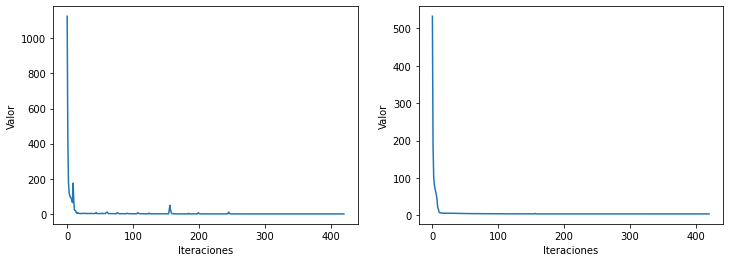

array([-0.9932861 ,  0.99665107,  0.99833032,  0.99916774,  0.9995852 ,
        0.99979328,  0.99989698,  0.99994866,  0.99997441,  0.99998725,
        0.99999365,  0.99999683,  0.99999842,  0.99999921,  0.99999961,
        0.9999998 ,  0.9999999 ,  0.99999995,  0.99999998,  0.99999999,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [22]:
X = np.ones(100, dtype=np.float128)
X[0] = X[-2] = -1.2

# X = np.ones(100, dtype=np.float128)
# X[4] = X[40] = 0.5
# X = np.ones(100) + np.random.normal(size=100)
xop = np.ones(100)

params = {
    'X': X,
    'f': rosembrock.function,
    'g': rosembrock.gradient,
    'h': rosembrock.hessian,
    'use_BB1': False, 
    'a0': 0.001,
    'tol_g': 1e-6,
    'mxitr': 10000,
    't1': 0.85,
    't2': 1.3,
}

# alg = BB()
# alg = ANGM()
# alg = ANGR1()
alg = ANGR2()

alg.optimize(**params)

print("iters: %d" % alg.iters)
print("g norm", np.linalg.norm(alg.g_norm_log[-1]))
print("f error", alg.f_log[-1] - rosembrock.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(alg.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(alg.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

alg.x_best

## Prueba Wood

iters: 242
g norm 2.6720616270798403e-09
f error 3.977053806482988e-21


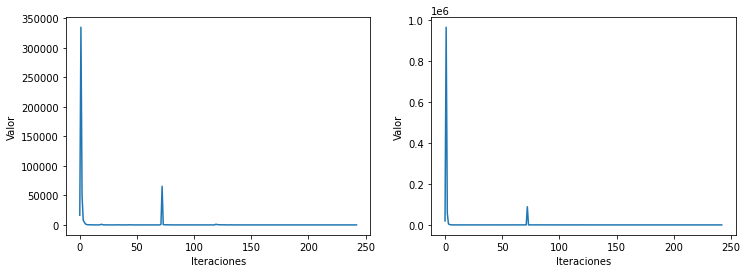

array([1., 1., 1., 1.])

In [23]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)
#X = np.random.rand(4)
# X = np.array([0.7, 0.5, 0.1, 0.8], dtype=np.float128)

xop = np.ones(4)


B_0 = wood.hessian(X)
H_0 = np.linalg.inv(B_0)

B_0 = np.identity(X.shape[0])

params = {
    'X': X,
    'f': wood.function,
    'g': wood.gradient,
    'h': wood.hessian,
    'use_BB1': False, 
    'a0': 0.001,
    'tol_g': 1e-6,
    'mxitr': 10000,
    't1': 0.4,
    't2': 1,
}

# alg = BB()
alg = ANGM()
# alg = ANGR1()
# alg = ANGR2()

alg.optimize(**params)

print("iters: %d" % alg.iters)
print("g norm", np.linalg.norm(alg.g_norm_log[-1]))
print("f error", alg.f_log[-1] - wood.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(alg.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(alg.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

alg.x_best